# Modelling music genres with Convolutional Neural Networks

The previous notebook was mostly about **data processing**:
- Download the initial data,
- Reduce it,
- Make it more readable.

Here, we will be using the output of that previous notebook.

## Importing the data we need

Note: the Google Drive download **should work** no matter the Google account the user may choose for the authentication.

In [12]:
!pip install librosa

    100% |████████████████████████████████| 1.6MB 17.6MB/s 
    100% |████████████████████████████████| 327kB 27.1MB/s 
    100% |████████████████████████████████| 3.2MB 11.4MB/s 
    100% |████████████████████████████████| 16.1MB 2.3MB/s 
  Running setup.py bdist_wheel for librosa ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy


In [13]:
# to install pytorch on colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x567e0000 @  0x7f994fcaf2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import librosa
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets

%matplotlib inline

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz

zip_id = '1n-sRLDAAZfdibGQXPYYo8v0s0rcDGJC6'
downloaded = drive.CreateFile({'id': zip_id})
downloaded.GetContentFile('zip_spectrogram.zip')

small_id = "1maJ4o_aHSy-ZLHUzOYuQ0QnRbS3rIciX"
downloaded = drive.CreateFile({'id': small_id})
downloaded.GetContentFile('small_tracks.csv')
tracks = pd.read_csv('small_tracks.csv')


tracks_id = "1me5bv76Fd9mFyJd25TSzOrl6SrcxsFFk"
downloaded = drive.CreateFile({'id': tracks_id})
downloaded.GetContentFile('tracks.csv')


#print('Downloaded content "{}"'.format(downloaded.GetContentString()))

The step of unzipping the spectrograms, and then loading them to the memory, still takes a bit of time, but it's not quite as ridiculous as the previous notebook.
- We only unzip 1,000 files instead of 8,000,
- Transforming the .txt files back into Numpy arrays only takes a bit less than three minutes, so it's still reasonable.

In [3]:
!unzip zip_spectrogram.zip

Archive:  zip_spectrogram.zip
   creating: spectrogram/
  inflating: spectrogram/109905.txt  
  inflating: spectrogram/126187.txt  
  inflating: spectrogram/122809.txt  
  inflating: spectrogram/116704.txt  
  inflating: spectrogram/003832.txt  
  inflating: spectrogram/127299.txt  
  inflating: spectrogram/152545.txt  
  inflating: spectrogram/004233.txt  
  inflating: spectrogram/108014.txt  
  inflating: spectrogram/031887.txt  
  inflating: spectrogram/063804.txt  
  inflating: spectrogram/042046.txt  
  inflating: spectrogram/145710.txt  
  inflating: spectrogram/043842.txt  
  inflating: spectrogram/114279.txt  
  inflating: spectrogram/006394.txt  
  inflating: spectrogram/004070.txt  
  inflating: spectrogram/092129.txt  
  inflating: spectrogram/092951.txt  
  inflating: spectrogram/048367.txt  
  inflating: spectrogram/006342.txt  
  inflating: spectrogram/081555.txt  
  inflating: spectrogram/143216.txt  
  inflating: spectrogram/044796.txt  
  inflating: spectrogram/126018.

In [4]:
len(os.listdir('spectrogram'))

1001

There is one extra file that appeared during the process and that we couldn't really get rid of before, so let's remove it now.

In [0]:
for file_name in os.listdir('spectrogram'):
  if file_name[-4:] != ".txt": # Remove the one file that does not have a .txt extension
    os.remove('spectrogram/' + file_name)

In [6]:
len(os.listdir('spectrogram'))

1000

Everything is in order: we can now import every text file in Numpy again.

In [7]:
import time

start_time = time.time()

file_dict = {} # A dictionary again!! It's because I can and because I like them

for file_name in os.listdir('spectrogram'):
  file_dict[file_name[:-4]] = np.loadtxt('spectrogram/%s' % file_name)
  
print('Time lapsed: %f' % (time.time() - start_time))

Time lapsed: 147.170223


## Image representation of a spectrogram

In [0]:
def spectrogram_display(file_name, display = "all"):
  """
  Input: the 6-digit code referring to an original .mp3 file
  Output: the according spectogram display
  
  Display == "all": we show the whole 30 second window
  Otherwise, display is an integer between 0 and 9, and corresponds to the
  first, second, ..., tenth 3-second window.
  """

  mel_spectrogram = file_dict[file_name]
  
  if display != "all":
    
    try:
      mel_spectrogram = np.split(mel_spectrogram, 10, 1)[display]
      track_start = 3 * display
      track_end = track_start + 4
      step = 0.5
    except (TypeError, ValueError, IndexError) as e:
      raise Exception('"display" should either be equal to "all" or to an integer between 0 and 9.')
      
  else:
    track_start = 0
    track_end = 31
    step = 5
    
  frame_number = mel_spectrogram.shape[1]
    
  plt.figure(figsize=(10, 4))
  plt.imshow(np.log(mel_spectrogram+1), origin="lower", aspect="auto", cmap="jet")
  plt.xticks(np.linspace(0, frame_number, 7), np.arange(track_start, track_end, step))
  plt.xlabel("time (seconds)"); plt.ylabel("mel scale"); plt.colorbar(); plt.tight_layout()
  plt.title("Spectrogram of track no. %s" % file_name)
  # plt.savefig("mel_spectrogram.png", dpi=300)
  plt.show()

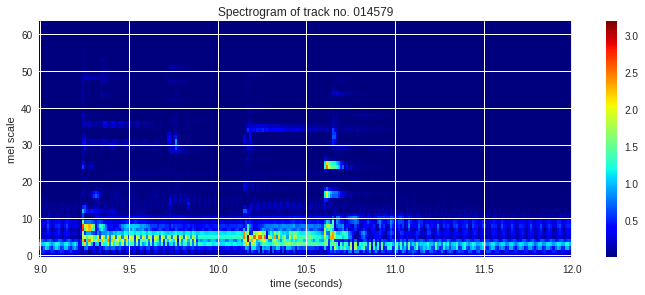

In [79]:
spectrogram_display('014579', display = 3)

Loss function: mean log loss?

Possible to use ResNet network and modify it a bit.
And then do classification based on that
Zhand et Al

## More data processing

Remember when I said that we were completely done with data pre-processing? **That was a lie.**

### Uniformisation of the track labels

In [0]:
tracks.track_id = tracks.track_id.apply(lambda x: str(x).rjust(6, '0'))
tracks.file_name = tracks.file_name.apply(lambda x: str(x).split('/')[1].replace('.mp3', '.txt'))
tracks.set_index('track_id', inplace = True)
tracks = tracks.reindex(file_dict.keys()).sort_index()

### Treating the data and splitting it into a training set, a validation set, and a test set

In [0]:
from sklearn.model_selection import train_test_split

train_labels, test_labels = train_test_split(tracks, test_size=0.1, random_state = 0)
train_labels, validation_labels = train_test_split(train_labels, test_size = 0.2/0.9, random_state = 0)
train_labels = train_labels.sort_index()
validation_labels = validation_labels.sort_index()
test_labels = test_labels.sort_index()

In [0]:
def track_aggregator(labels, file_dict = file_dict):
  
  """
  Replace labels by train_labels or test_labels in order to get the proper input,
  either for the train dataset or the test dataset
  """
  
  return np.array([np.split(file_dict[track_id], 10, 1)[i] for track_id in labels.index for i in range(0,10)])


def genre_multiplier(labels, multiplier = 10):
  
  """
  Since we split our tracks into ten 3-second long tracks, we need to multiply
  the number of labels by ten every time.
  """
  
  genre_list = []
  
  for genre in labels.genres:
    genre = [genre] * multiplier
    genre_list += genre
    
  return genre_list

In [0]:
# Our track spectrograms
train_tracks = track_aggregator(train_labels)
validation_tracks = track_aggregator(validation_labels)
test_tracks = track_aggregator(test_labels)

In [0]:
# Our genre labels (should correspond for each row)
train_genres = genre_multiplier(train_labels)
validation_genres = genre_multiplier(validation_labels)
test_genres = genre_multiplier(test_labels)

Source: https://pytorch.org/docs/stable/torchvision/models.html

In [116]:
train_tracks.shape

(7000, 64, 258)

Form of the input: An image of dimension $64 \times 258$, with a single channel (equivalent to black / white)

In [77]:
tracks

,genres,file_name
track_id,,
000207,Folk,000207.txt
000615,Experimental,000615.txt
000625,Folk,000625.txt
000666,International,000666.txt
000695,Hip-Hop,000695.txt
000704,International,000704.txt
000707,International,000707.txt
000709,International,000709.txt
000777,Rock,000777.txt


In [0]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

In [60]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [61]:
file_dict.keys()

dict_keys(['141290', '014579', '066075', '064989', '092556', '067597', '073343', '126430', '004094', '113511', '003721', '108014', '133431', '006358', '050752', '073175', '032001', '065745', '120184', '097590', '010678', '038557', '118954', '067359', '004070', '115724', '153452', '099371', '097697', '133436', '127290', '038779', '004778', '127469', '089814', '094026', '115273', '023155', '138069', '086724', '057439', '054666', '128878', '003896', '045518', '135989', '052448', '070174', '063804', '059725', '001193', '067010', '028692', '096401', '067235', '075401', '110110', '128882', '112486', '000695', '026905', '047835', '006390', '128666', '019179', '114544', '003766', '134979', '043698', '122088', '072136', '131791', '033992', '075441', '115849', '004236', '075782', '107020', '108475', '115922', '131939', '014738', '015464', '105119', '076437', '006354', '113284', '048763', '072738', '084057', '091312', '067673', '067764', '020432', '124186', '111386', '148510', '122675', '105142',

In [0]:
for key, value in file_dict.items():
  if value.shape[1] != 2580:
    print(key)